In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import numpy as np 
import scanpy as sc
import scipy
import scanorama
import pandas as pd 
import matplotlib.pyplot as plt
import anndata as ad
from scipy.sparse import csr_matrix, issparse

In [3]:
#All data, with pseudo time for trajectory metric calculation.

#adata = sc.read("/dev/shm/backup/Concatenated_E55_pseudoT.h5ad")
#adata.obs.rename(columns = {"cell_type":"Cell_Type"},inplace=True)
#adata.X = adata.layers["counts"]
#unintegrated_data = adata.copy()

In [4]:
# Data : Ribo -hb filtered.
adata = sc.read("/home/ubuntu/scib-pipeline/data/Concatenated_E55_pseudoT_RMhb_RMrebo.h5ad")
#adata.obs.rename(columns = {"CellType_merged":"Cell_Type"},inplace=True)
adata.obs.rename(columns = {"cell_type":"Cell_Type"},inplace=True)
adata.X = adata.layers["counts"]
unintegrated_data = adata.copy()

In [5]:
adata.obs.Cell_Type.value_counts()

EPI     8133
ExE     2605
exVE     606
emVE     431
VE       420
Name: Cell_Type, dtype: int64

In [6]:
counts = adata.obs.groupby(['Cell_Type', 'batch_id']).size()
count_table = counts.unstack(level=0)
count_table

Cell_Type      EPI   ExE   VE  emVE  exVE
batch_id                                 
Argelaguet     113     0   55     0     0
Cheng          115    43  111     0     0
Nowotschin_1  1196   666   10   153    47
Nowotschin_2  3925  1320    5   115   258
Nowotschin_3  2758   565   24   163   301
Thowfeequ       26    11  215     0     0

In [7]:
#adata = sc.read("../../Ömer/data/scVI_notfiltered.h5ad")
#unintegrated_data = adata.copy()

In [9]:
adata.obs.batch_id.value_counts()

Nowotschin_2    5623
Nowotschin_3    3811
Nowotschin_1    2072
Cheng            269
Thowfeequ        252
Argelaguet       168
Name: batch_id, dtype: int64

# Integration

In [10]:
# HVG calculation

# sc.pp.highly_variable_genes(
#     adata,
#     flavor="seurat_v3",
#     n_top_genes =4000,
#     batch_key="batch_id",
#     subset=True
# )

In [ ]:
import scib
import scvi

## ScVI

In [12]:
scvi.model.SCVI.setup_anndata(adata, layer="counts", batch_key="batch_id")

In [13]:
vae = scvi.model.SCVI(adata, n_layers=2, n_latent=30)#, gene_likelihood="nb")

In [14]:
print(vae)
# vae.view_anndata_setup()

SCVI Model with the following params: 
n_hidden: 128, n_latent: 30, n_layers: 2, dropout_rate: 0.1, dispersion: gene, gene_likelihood: zinb, 
latent_distribution: normal
Training status: Not Trained

In [15]:
vae.train()

/home/ubuntu/miniconda3/envs/scib-pipeline-R4.0/lib/python3.7/site-packages/torch/distributed/_sharded_tensor/__init__.py:10: DeprecationWarning: torch.distributed._sharded_tensor will be deprecated, use torch.distributed._shard.sharded_tensor instead
  DeprecationWarning
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 1/400:   0%|                                                                   | 0/400 [00:00<?, ?it/s]

/home/ubuntu/miniconda3/envs/scib-pipeline-R4.0/lib/python3.7/site-packages/scvi/distributions/_negative_binomial.py:438: UserWarning: The value argument must be within the support of the distribution
  UserWarning,


Epoch 400/400: 100%|███████████████████████████████| 400/400 [07:24<00:00,  1.11s/it, loss=2.59e+03, v_num=1]


In [16]:
adata_scANVI = adata.copy()

In [17]:
adata.obsm["X_scVI"] = vae.get_latent_representation()
sc.pp.neighbors(adata, use_rep="X_scVI",key_added = "scVI_neighbors")
sc.tl.leiden(adata, neighbors_key="scVI_neighbors", key_added = "scVI_leiden",resolution = 0.15)
sc.tl.umap(adata,neighbors_key="scVI_neighbors")
adata

AnnData object with n_obs × n_vars = 12195 × 4000
    obs: 'Cell_Type', 'batch_id', 'batch', 'CellType_merged', 'n_genes', 'n_counts', 'log1p_rebo_express', 'log1p_hb_express', 'dpt_pseudotime', '_scvi_batch', '_scvi_labels', 'scVI_leiden'
    var: 'rebo', 'hb', 'gene_symbol-0', 'highly_variable-0', 'means-0', 'dispersions-0', 'dispersions_norm-0', 'highly_variable-1', 'means-1', 'dispersions-1', 'dispersions_norm-1', 'highly_variable-2', 'means-2', 'dispersions-2', 'dispersions_norm-2', 'highly_variable-3', 'means-3', 'dispersions-3', 'dispersions_norm-3', 'highly_variable-4', 'means-4', 'dispersions-4', 'dispersions_norm-4', 'highly_variable-5', 'means-5', 'dispersions-5', 'dispersions_norm-5', 'highly_variable-6', 'means-6', 'dispersions-6', 'dispersions_norm-6', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'hvg', '_scvi_uuid', '_scvi_manager_uuid', 'scVI_neighbors', 'leiden', 'umap'
    obsm: 'X_pca', 'X_umap

### Graphs

/home/ubuntu/miniconda3/envs/scib-pipeline-R4.0/lib/python3.7/site-packages/scanpy/_settings.py:447: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  IPython.display.set_matplotlib_formats(*ipython_format)


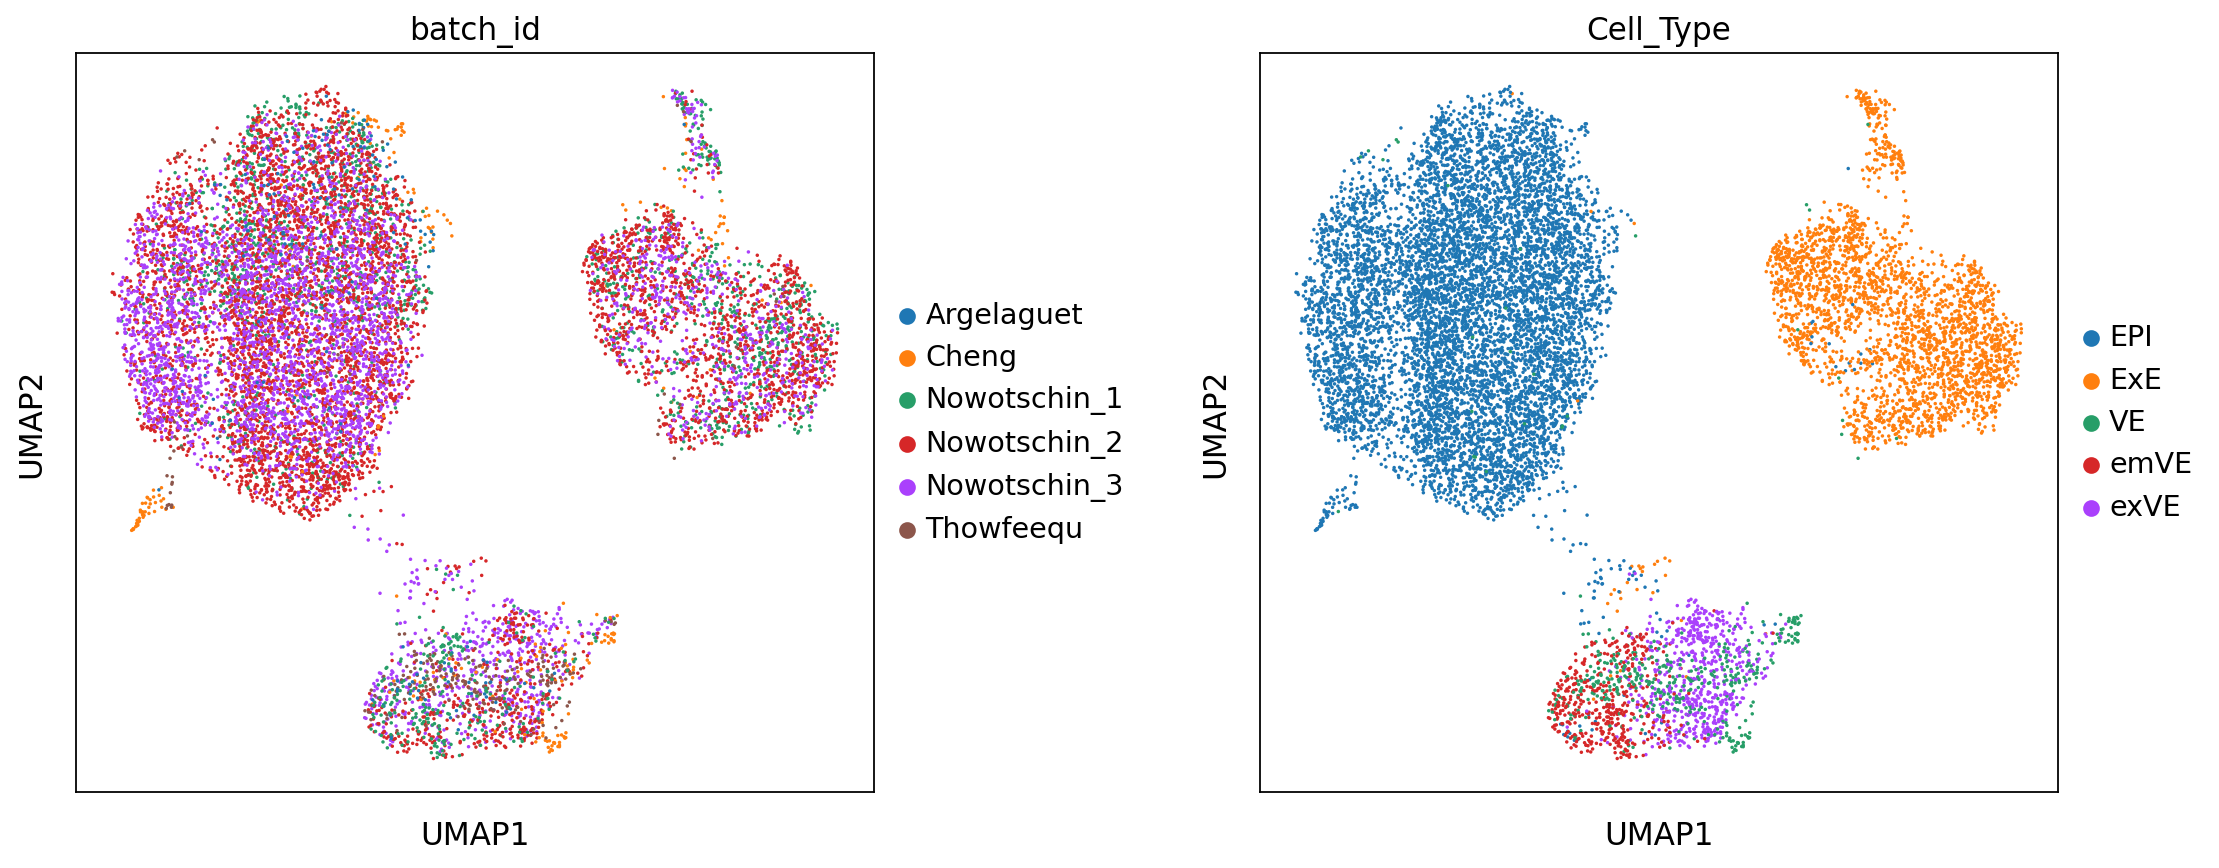

In [18]:
sc.set_figure_params(figsize=(6, 6))
sc.pl.umap(adata, color=[ "batch_id" , "Cell_Type"], neighbors_key = "scVI_neighbors", ncols=2,wspace=0.35)

In [19]:
sc.tl.tsne(adata, use_rep = "X_scVI" )

/home/ubuntu/miniconda3/envs/scib-pipeline-R4.0/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


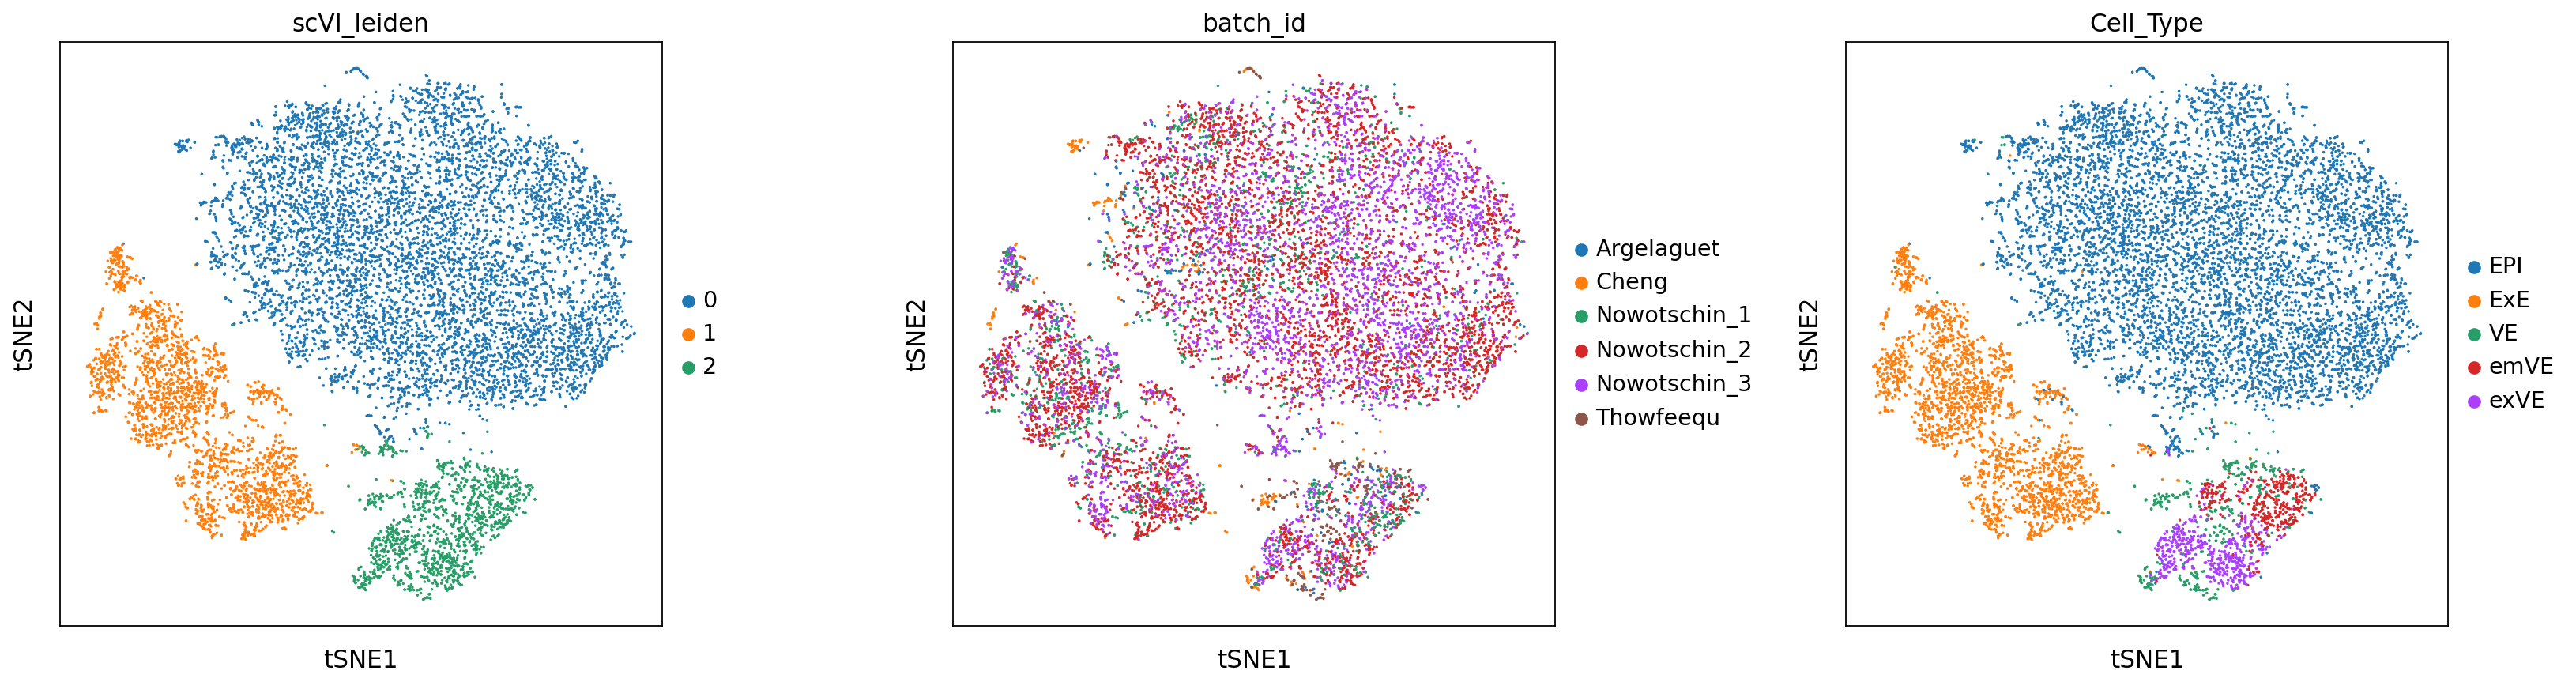

In [20]:
sc.pl.tsne(adata,color=["scVI_leiden" , "batch_id" , "Cell_Type"], ncols=3,wspace=0.35)

In [21]:
# adata.write("../Ömer/data/scVI_notfiltered.h5ad")
# vae.save("scVI_notfiltered")

In [22]:
# vae = scvi.model.SCVI.load("../Ömer/scvi_model/scvi_mouse.h5ad", adata=all_data)

## ScANVI

In [23]:
adata_scANVI

AnnData object with n_obs × n_vars = 12195 × 4000
    obs: 'Cell_Type', 'batch_id', 'batch', 'CellType_merged', 'n_genes', 'n_counts', 'log1p_rebo_express', 'log1p_hb_express', 'dpt_pseudotime', '_scvi_batch', '_scvi_labels'
    var: 'rebo', 'hb', 'gene_symbol-0', 'highly_variable-0', 'means-0', 'dispersions-0', 'dispersions_norm-0', 'highly_variable-1', 'means-1', 'dispersions-1', 'dispersions_norm-1', 'highly_variable-2', 'means-2', 'dispersions-2', 'dispersions_norm-2', 'highly_variable-3', 'means-3', 'dispersions-3', 'dispersions_norm-3', 'highly_variable-4', 'means-4', 'dispersions-4', 'dispersions_norm-4', 'highly_variable-5', 'means-5', 'dispersions-5', 'dispersions_norm-5', 'highly_variable-6', 'means-6', 'dispersions-6', 'dispersions_norm-6', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'hvg', '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'X_pca', 'X_umap'
    layers: 'counts'

In [24]:
# adata.obs["cell_type"] = adata.obs.CellType_merged.copy()
# adata.obs["cell_type"] = adata.obs["cell_type"].cat.add_categories('Unknown')
# adata.obs.cell_type = adata.obs.cell_type.replace({'NA':'Unknown'})

In [25]:
lvae = scvi.model.SCANVI.from_scvi_model(
    vae,
    adata=adata_scANVI,
    labels_key="Cell_Type",
    unlabeled_category="Unknown",
)

INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


In [26]:
lvae.train(max_epochs=20, n_samples_per_label=100)

INFO     Training for 20 epochs.                                                                                   


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 1/20:   0%|                                                                     | 0/20 [00:00<?, ?it/s]

/home/ubuntu/miniconda3/envs/scib-pipeline-R4.0/lib/python3.7/site-packages/scvi/distributions/_negative_binomial.py:438: UserWarning: The value argument must be within the support of the distribution
  UserWarning,


Epoch 20/20: 100%|███████████████████████████████████| 20/20 [00:44<00:00,  2.21s/it, loss=2.62e+03, v_num=1]


In [27]:
# lvae.save("../Ömer/scvi_model/scanvi_not_filtered.h5ad")

In [28]:
adata_scANVI.obsm["X_scANVI"] = lvae.get_latent_representation(adata_scANVI)

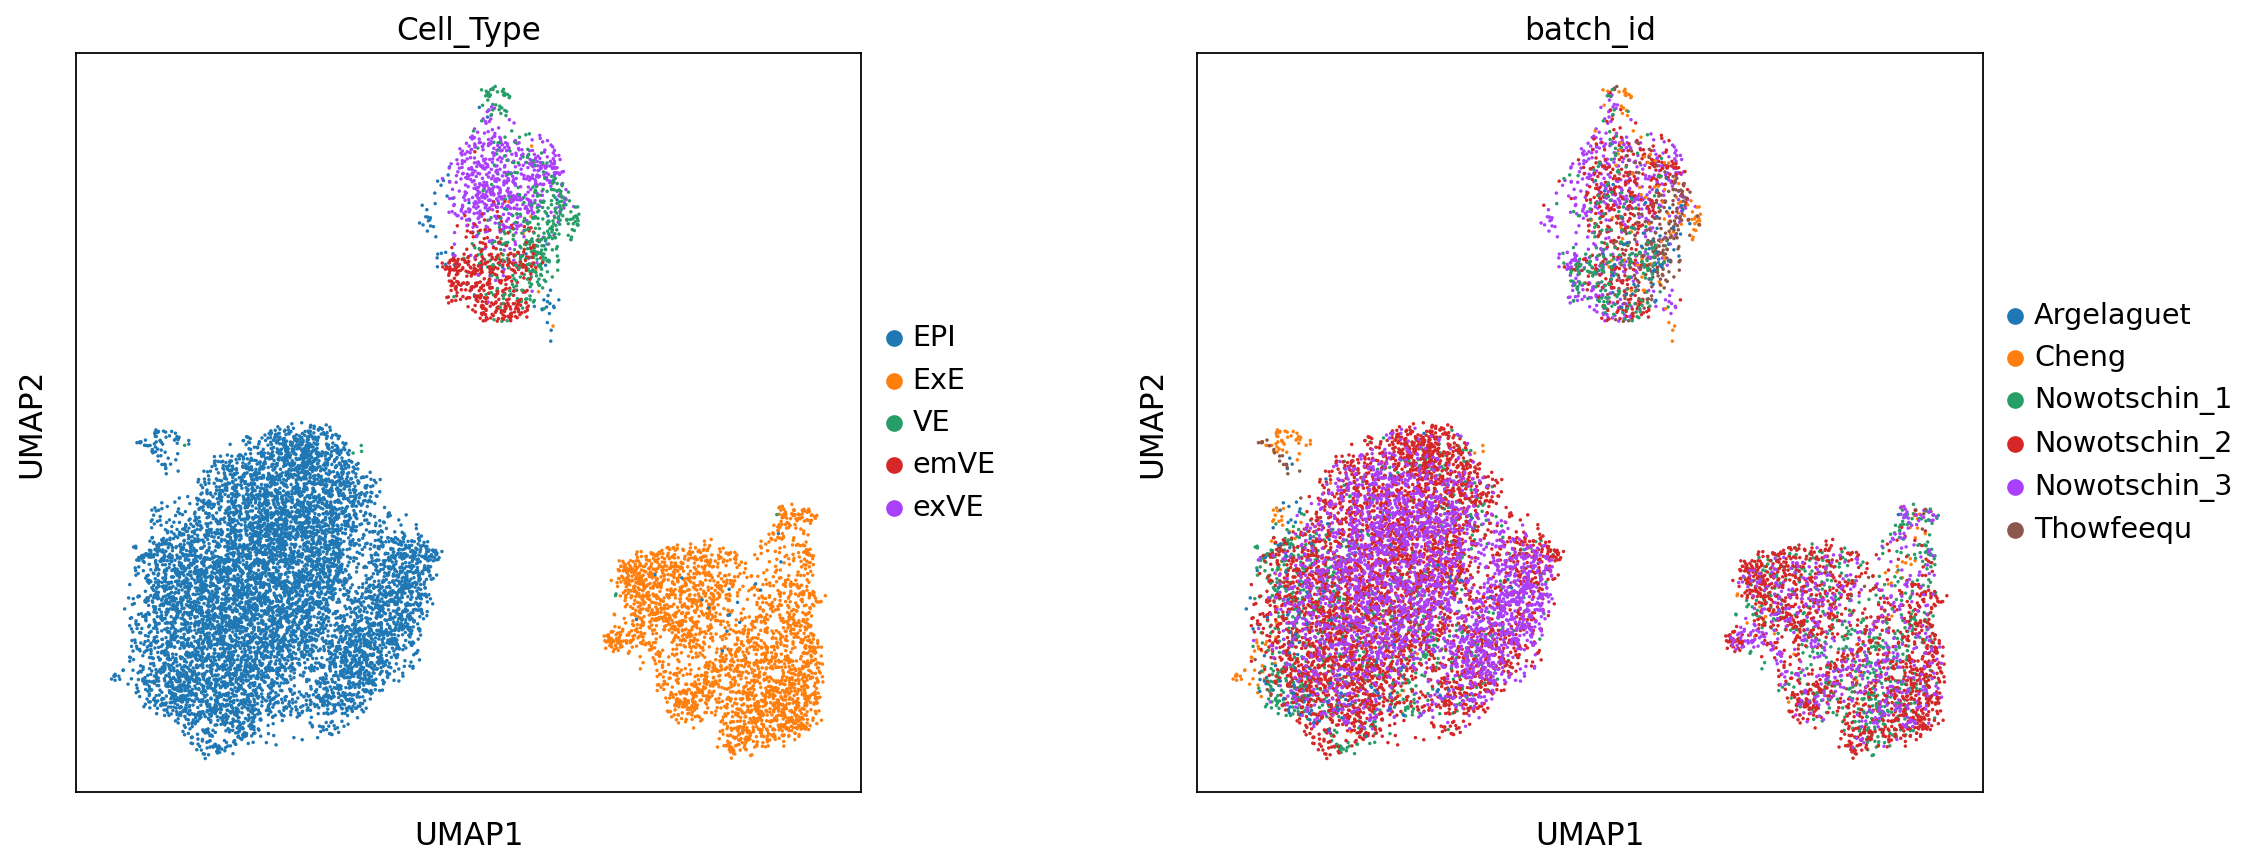

In [29]:
sc.pp.neighbors(adata_scANVI, use_rep="X_scANVI",key_added = "scANVI_neighbors")
sc.tl.leiden(adata_scANVI, neighbors_key="scANVI_neighbors", key_added = "leiden_scANVI",resolution = 0.15)
sc.tl.umap(adata_scANVI,neighbors_key="scANVI_neighbors")
sc.pl.umap(adata_scANVI, color=["Cell_Type" , "batch_id"], neighbors_key = "scANVI_neighbors", ncols=3,wspace=0.3)

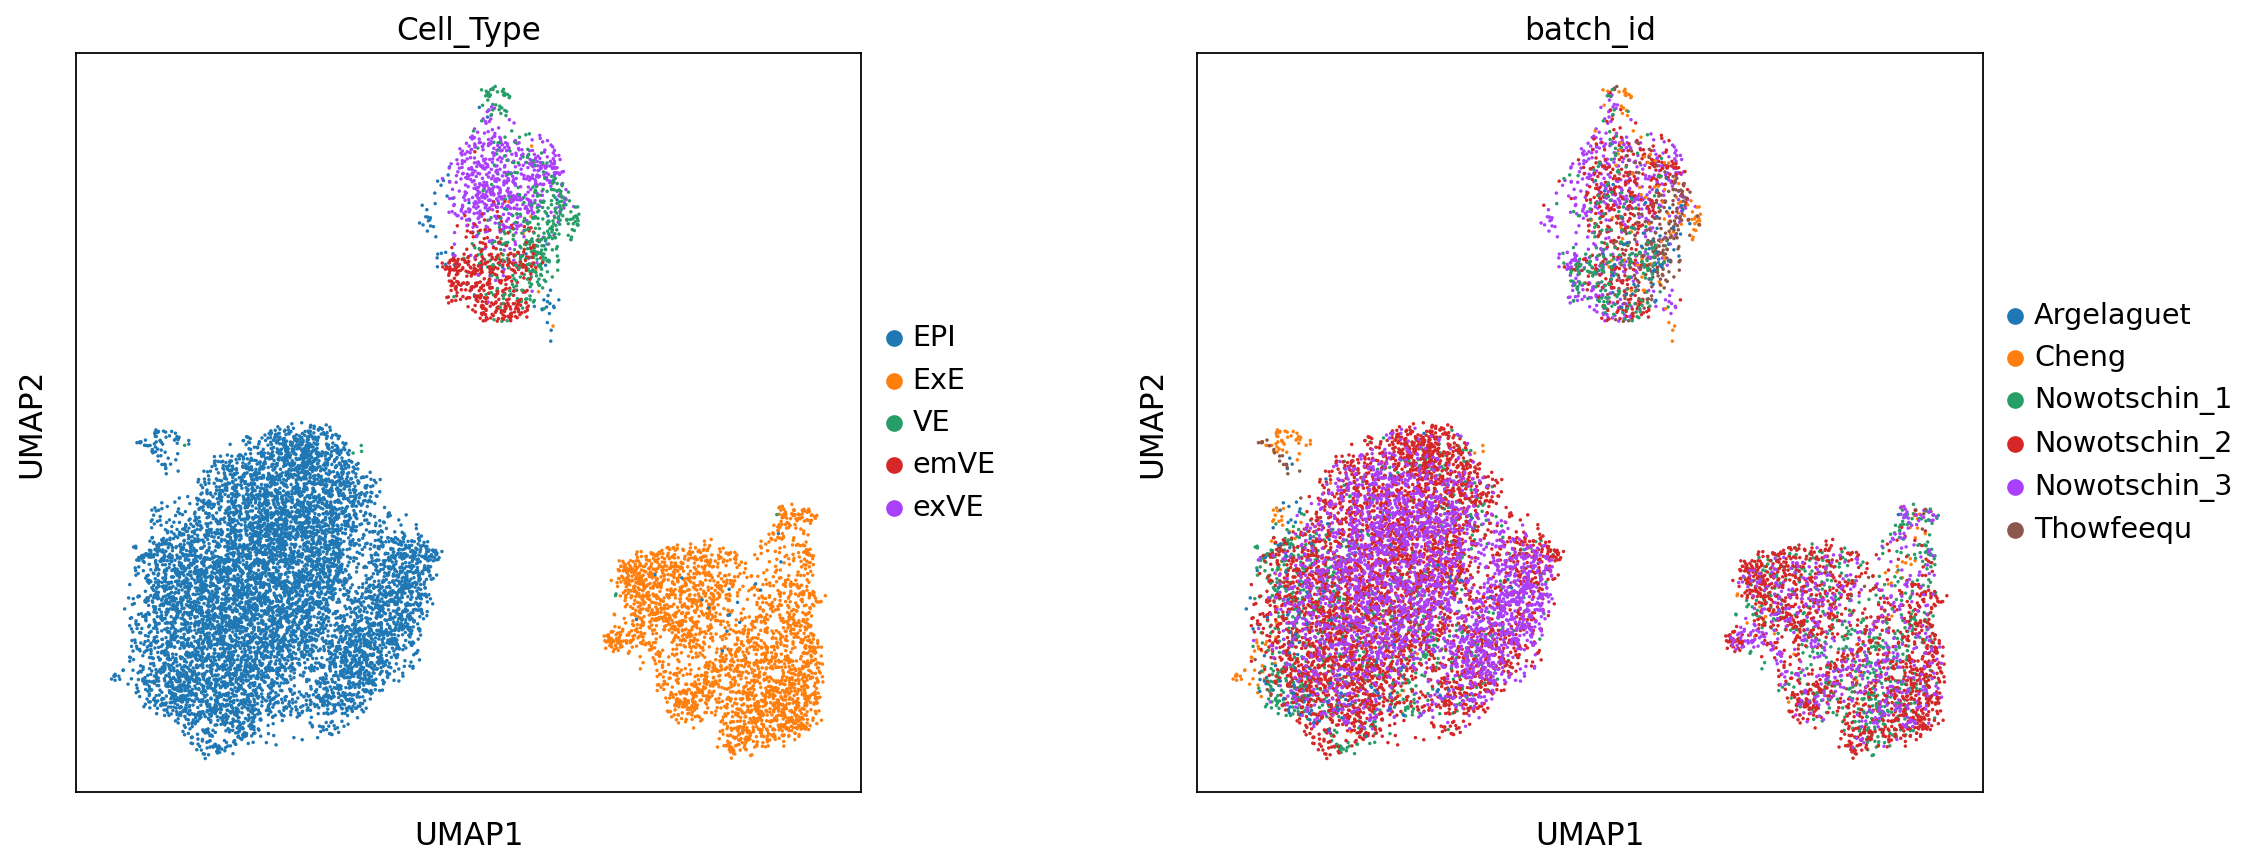

In [30]:
sc.pl.umap(adata_scANVI, color=["Cell_Type" , "batch_id"], neighbors_key = "scANVI_neighbors", ncols=3,wspace=0.3)

# Cell Type annonations for Argelaguet from scANVI 

- ScANVI can be used to get cell-type prediction

In [31]:
# a_adata.obs.CellType_merged.value_counts()

In [32]:
# adata.obs["cell_type_prediction"] = lvae.predict(adata)
# a_adata = adata[adata.obs.batch_id == 'Argelaguet']
# a_adata.obs['pred_key'] = a_adata.obs.index
# cell_mapper = dict(zip(a_adata.obs.pred_key, a_adata.obs.cell_type_prediction))
# np.save("../Ömer/argelaguet_cell_type_dict.npy", cell_mapper) 

# Metrics

In [33]:
import scib

In [34]:
unintegrated_data.layers["counts"] = unintegrated_data.X.copy()

In [35]:
unintegrated_data.obs["batch_id"]= unintegrated_data.obs["batch_id"].astype('category')
unintegrated_data.obs["Cell_Type"]= unintegrated_data.obs["Cell_Type"].astype('category')

In [36]:
# sc.tl.leiden(adata, neighbors_key="scVI_neighbors", key_added = 'leiden_scVI')
# sc.tl.leiden(adata_scANVI, neighbors_key="scANVI_neighbors", key_added = 'leiden_scANVI' )

In [37]:
metrics_scVI = scib.metrics.metrics(unintegrated_data, adata, batch_key='batch_id', label_key='Cell_Type', embed='X_scVI', cluster_key='cluster', cluster_nmi=None, ari_=True,
                        #nmi_=True, nmi_method='arithmetic', nmi_dir=None, silhouette_=True, si_metric='euclidean', pcr_=True,
                        #cell_cycle_=True, organism='mouse', hvg_score_=True, isolated_labels_=True, isolated_labels_f1_=True,
                        #isolated_labels_asw_=True, n_isolated=None, graph_conn_=True, trajectory_=True, kBET_=True, lisi_graph_=True,
                        #ilisi_=True, clisi_=True, subsample=0.5, n_cores=1, type_=None, verbose=True)

metrics_scANVI = scib.metrics.metrics(unintegrated_data, adata_scANVI, batch_key='batch_id', label_key='Cell_Type', embed='X_scANVI', cluster_key='cluster', cluster_nmi=None, ari_=True,
                        #nmi_=True, nmi_method='arithmetic', nmi_dir=None, silhouette_=True, si_metric='euclidean', pcr_=True,
                        #cell_cycle_=True, organism='mouse', hvg_score_=True, isolated_labels_=True, isolated_labels_f1_=True,
                        #isolated_labels_asw_=True, n_isolated=None, graph_conn_=True, trajectory_=True, kBET_=True, lisi_graph_=True,
                        #ilisi_=True, clisi_=True, subsample=0.5, n_cores=1, type_=None, verbose=True)

In [38]:
#metrics_scVI.to_csv("../metrics/scVI_HVG.csv")
#metrics_scANVI.to_csv("../metrics/scANVI_HVG.csv")

In [ ]:
metrics = pd.concat(
    [metrics_scVI, metrics_scANVI],
    axis="columns",
)

In [ ]:
metrics = metrics.set_axis(
    ["metrics_scVI", "metrics_scANVI"], axis="columns"
)

In [ ]:
metrics

In [41]:
# met = met.reset_index(level=0)
# met.rename(columns= {met.columns[0] : 'metrics'}, inplace= True)